In [30]:
# Global imports
import numpy as np
import cv2

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading Caltech101 dataset

In [31]:
import torchvision.datasets as datasets

dataset_path = "C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Phase 1\Datasets"

dataset = datasets.Caltech101(
    root=dataset_path,
    download=False,  # True if downloading for first time
)


Select image by ID

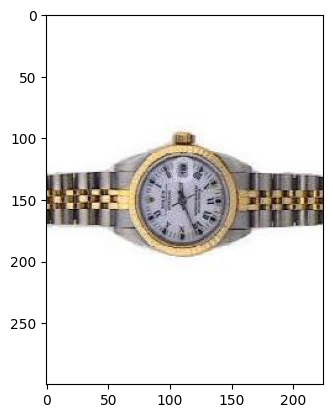

In [48]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(sample_image)
plt.show()


In [ ]:
# Class transform to partition image into rows x cols grid


class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                top = i * cell_height
                right = left + cell_width
                bottom = top + cell_height
                grid = img.crop((left, top, right, bottom))
                grids.append(grid)

        return grids


### Feature model 1: Color moments

In [33]:
from scipy.stats import skew


def compute_color_moments(image):
    image = np.array(image)  # Convert PIL Image to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)
        std_dev = np.std(channel_data)
        skewness = skew(channel_data, axis=None)
        moments.append([mean, std_dev, skewness])

    return moments


# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


In [34]:
def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(
        10, 10, 3, 3
    )  # resize as needed: 10x10 grid, 3 channels per cell, 3 moments per channel


Composed color moment transform (CM10x10)

In [35]:
CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid,
        combine_color_moments,
    ]
)

if np.array(sample_image).shape[2] >= 3:
    # no color moments for grayscale images
    cm_fd = CM_transform(sample_image)
else:
    cm_fd = torch.zeros((10, 10, 3, 3)) #TODO: store with some flag to indicate grayscale

print(np.array(cm_fd))


[[[[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+0

(note that skewness is NaN when all elements are equal i.e. std. dev. = 0)

#### Visualizing color moments - stacked bar chart

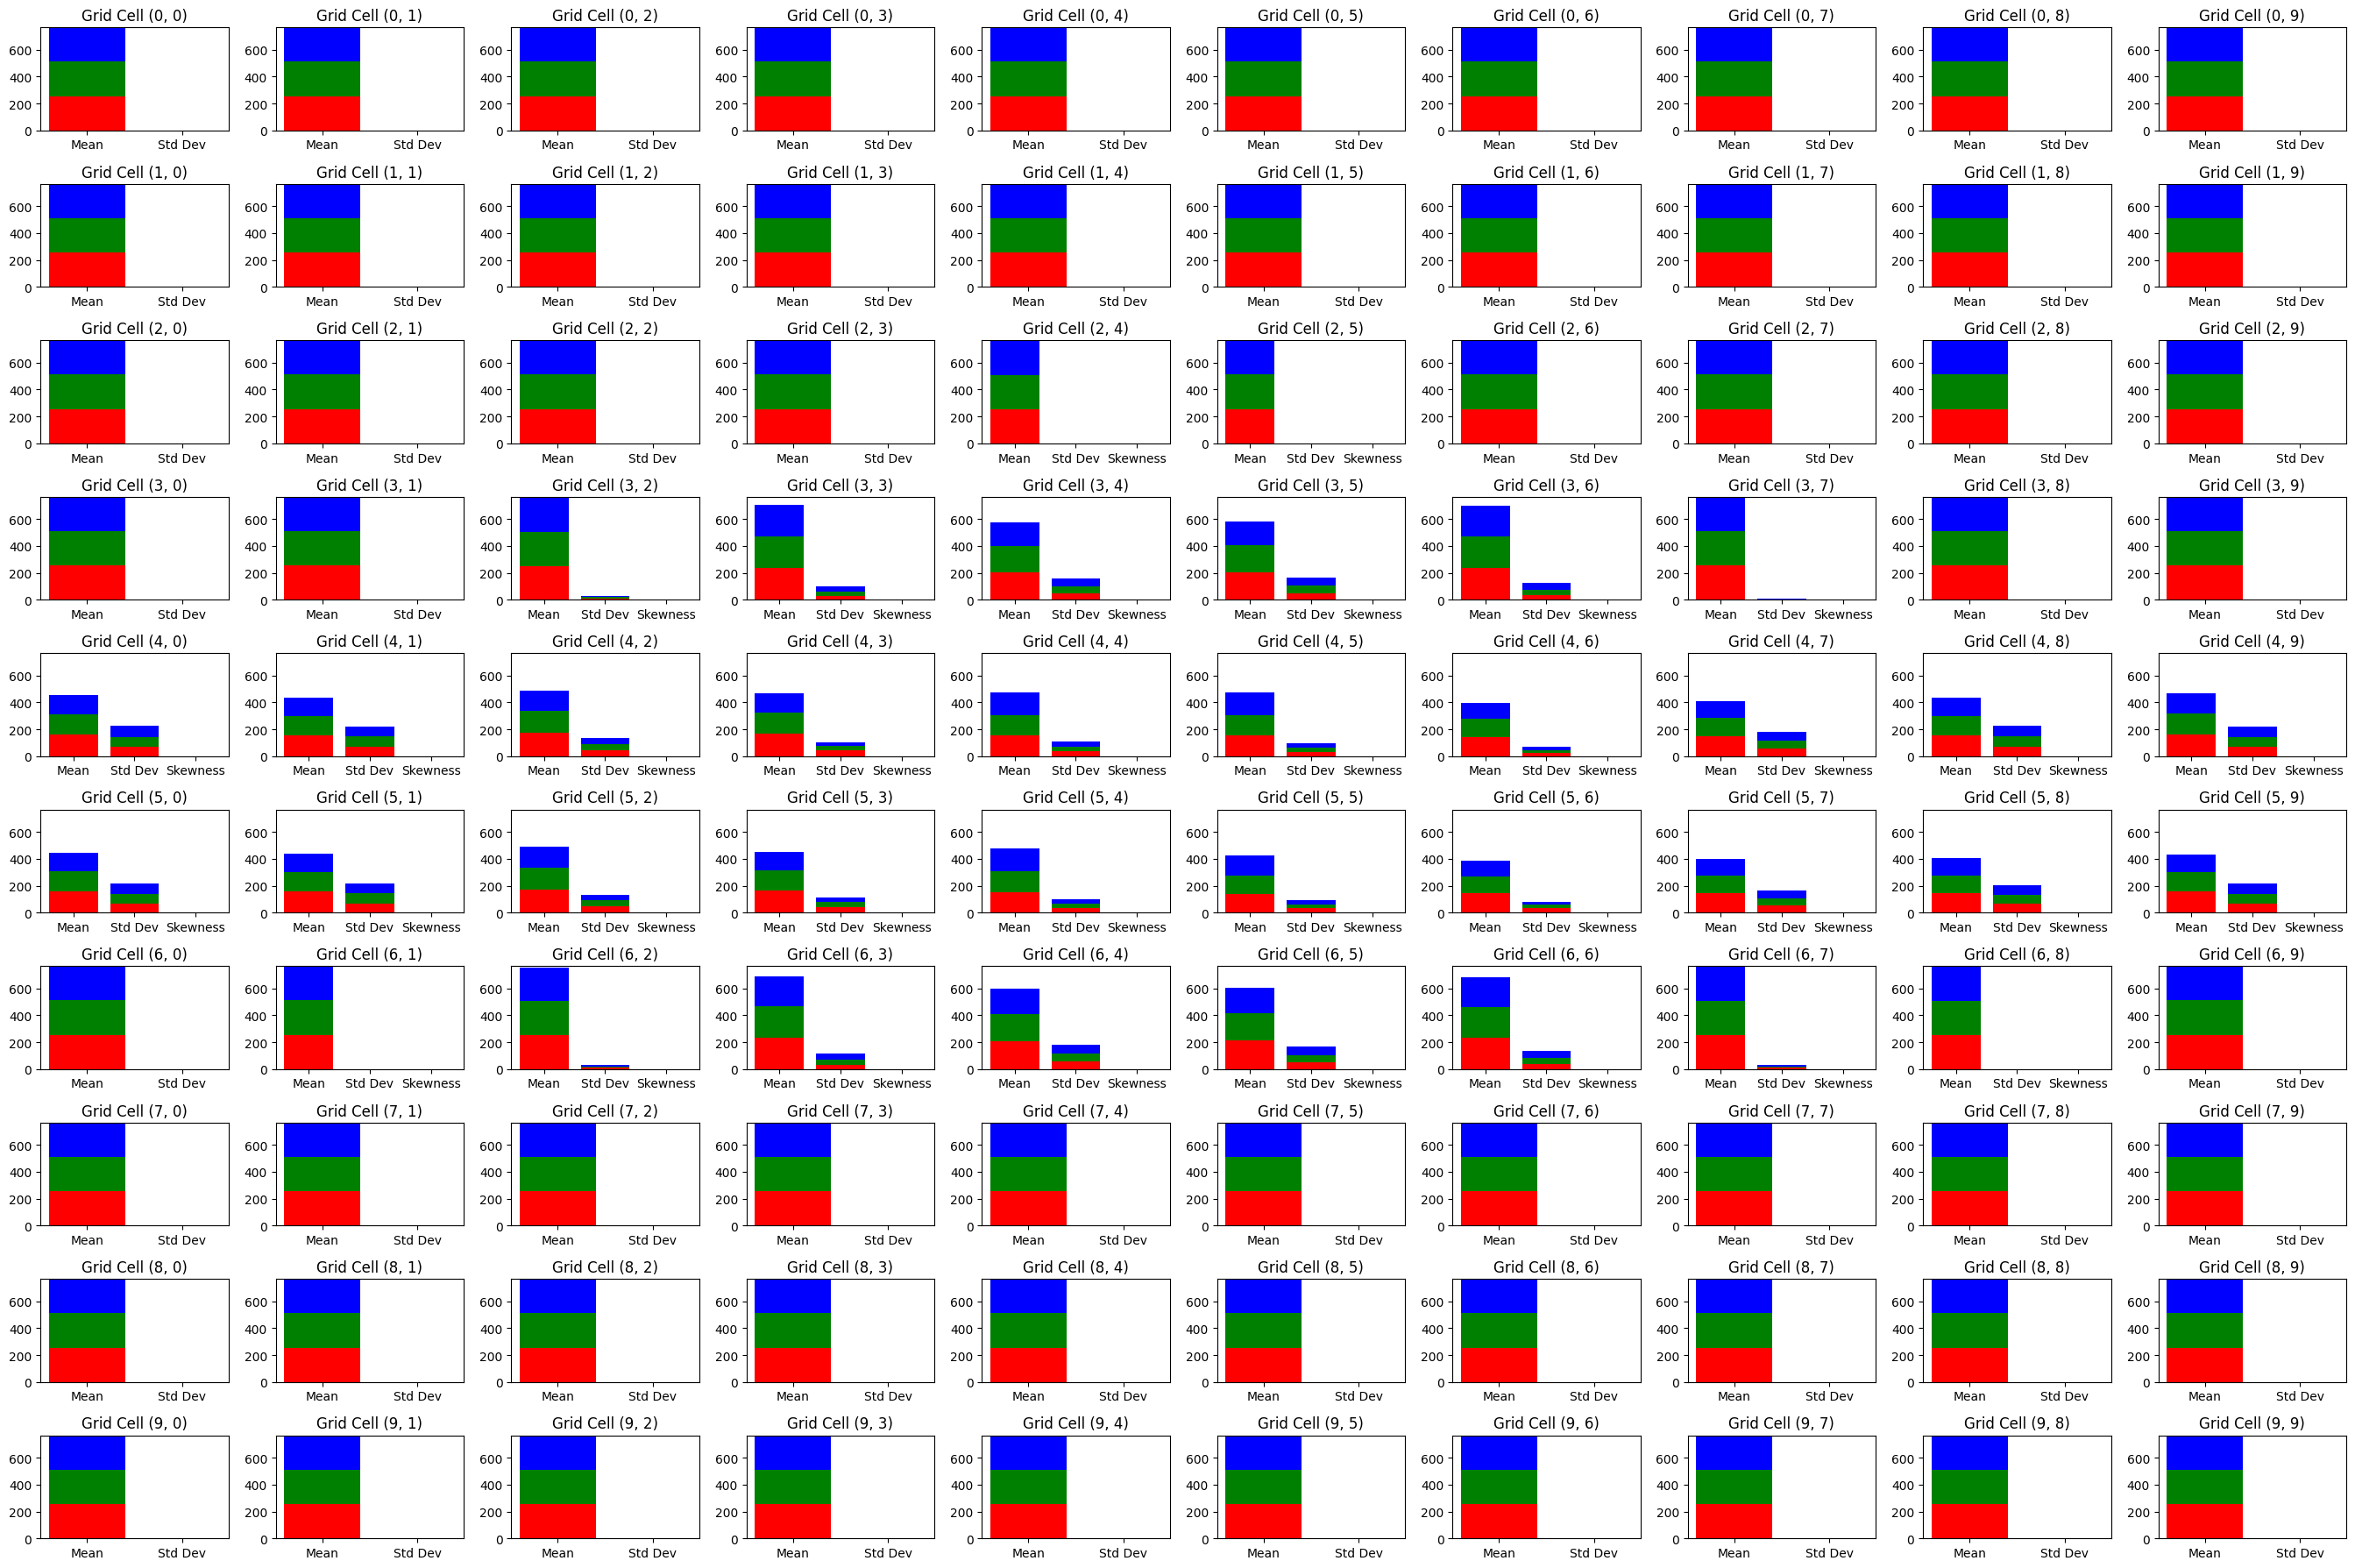

In [36]:
# cm_fd should be a NumPy array of shape (M, N, 3, 3), where (M, N) is the grid size

# Define the number of grid cells (M and N)
M, N = cm_fd.shape[:2]

# Create subplots for each color moment (mean, standard deviation, skewness)
fig, axes = plt.subplots(M, N, figsize=(27, 18))

# Loop through each grid cell and visualize the color moments as stacked bar charts
for i in range(M):
    for j in range(N):
        moments = cm_fd[i, j]
        colors = ["red", "green", "blue"]

        for c in range(3):
            ax = axes[i, j]
            ax.bar(
                ["Mean", "Std Dev", "Skewness"],
                moments[c],
                color=colors[c],
                bottom=np.sum(np.array(moments[:c]), axis=0),
            )  # stack channels
            ax.set_ylim(
                0, 3 * 255
            )  # since max possible meanset can be [255, 255, 255] for entirely white grid cell
            ax.set_title(f"Grid Cell ({i}, {j})")


# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


Feature model 2: Histogram Oriented Gradients (HOG)

In [37]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.uint8)

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=1, dy=0, ksize=1
    )  # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(
        grid_array, cv2.CV_32F, dx=0, dy=1, ksize=1
    )  # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    # Compute HOG - 9 bins, counted across the range of -180 to 180 degrees, weighted by gradient magnitude
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms

In [38]:
def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


In [39]:
def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


In [40]:
HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # grayscale transform
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(
            rows=10, cols=10
        ),  # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)

hog_fd = HOG_transform(sample_image)
print(np.array(hog_fd))


[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0

Visualizing HOG as histograms

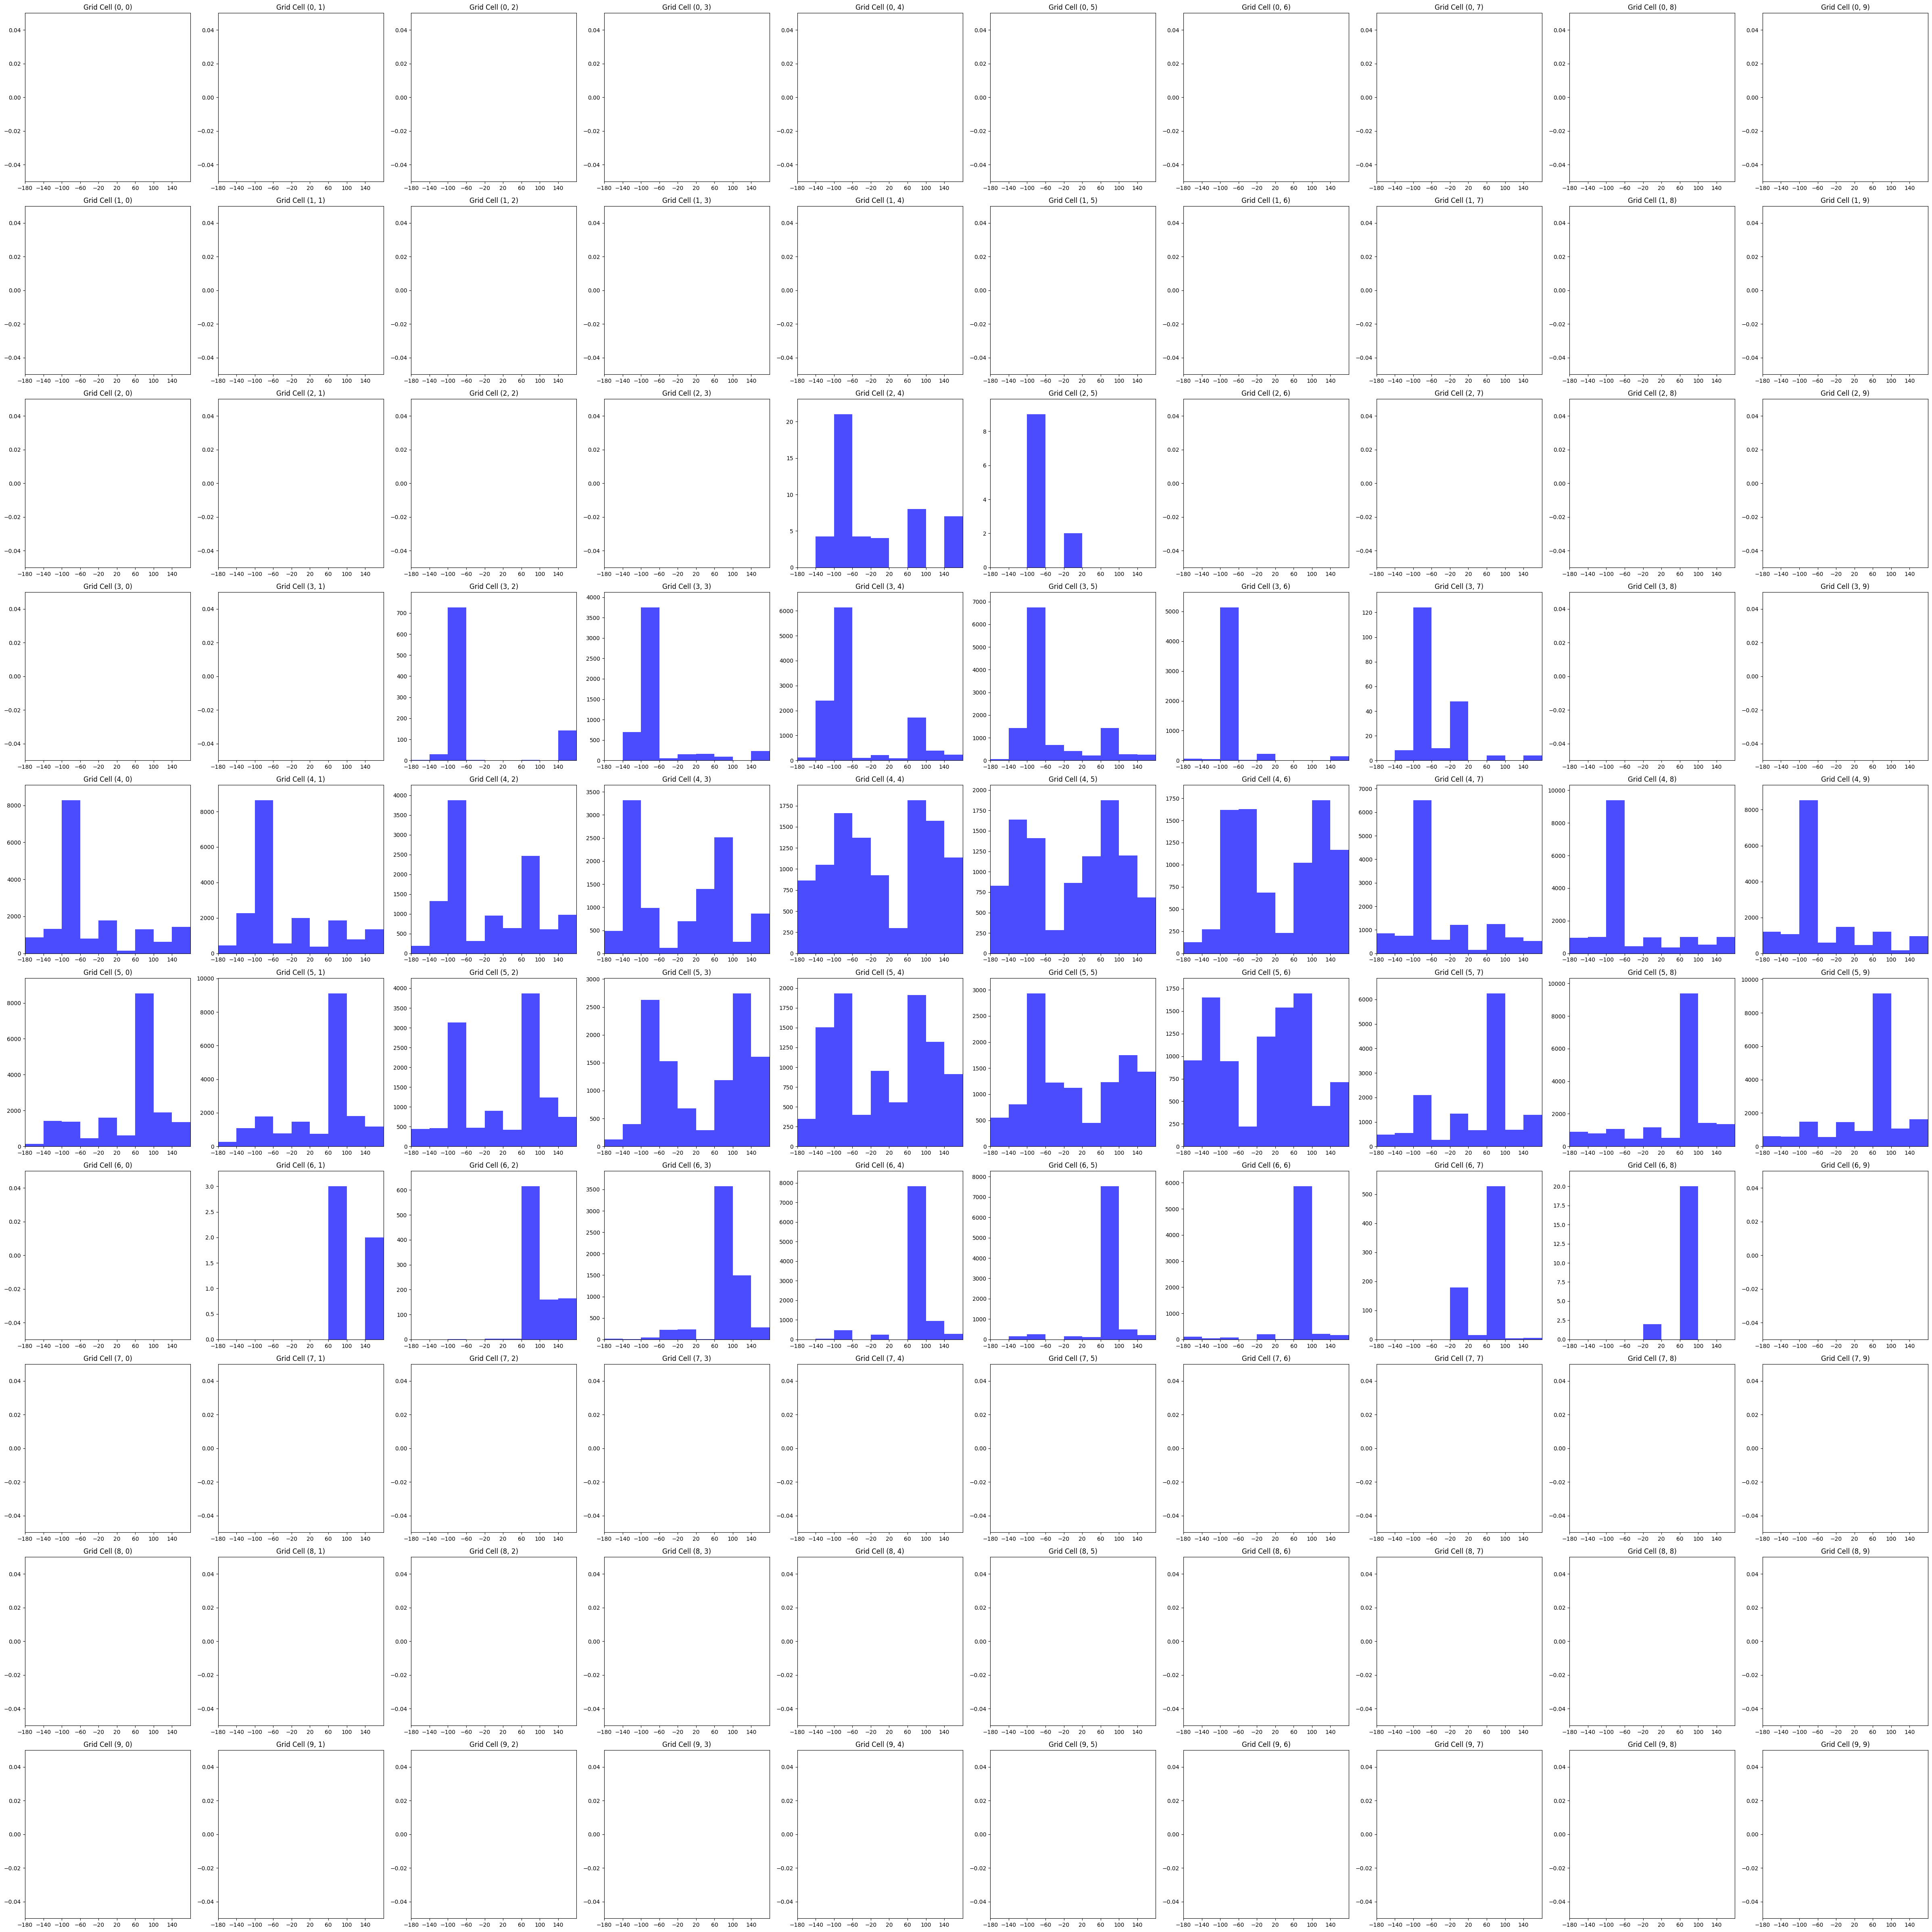

In [41]:
# # The 'hog' should now contain the 10x10x9 feature descriptor
# # Reshape it to a 10x10 grid of histograms, each of shape (9,)
histograms = np.array(hog_fd.reshape(10, 10, 9))

# # Visualize the histograms
fig, axes = plt.subplots(10, 10, figsize=(48, 48))
for i in range(10):
    for j in range(10):
        histogram = histograms[i, j]
        angles = np.linspace(-180, 180, 9, endpoint=False)

        axes[i, j].bar(angles, histogram, width=40, align="edge", color="b", alpha=0.7)
        axes[i, j].set_xlim(-180, 180)
        axes[i, j].set_ylim(0, np.max(histogram) * 1.1)
        axes[i, j].set_xticks([-180, -140, -100, -60, -20, 20, 60, 100, 140])
        axes[i, j].set_title(f"Grid Cell ({i}, {j})")

plt.tight_layout()
plt.show()


### Visualizing HOG gradient directions as an arrow overlay

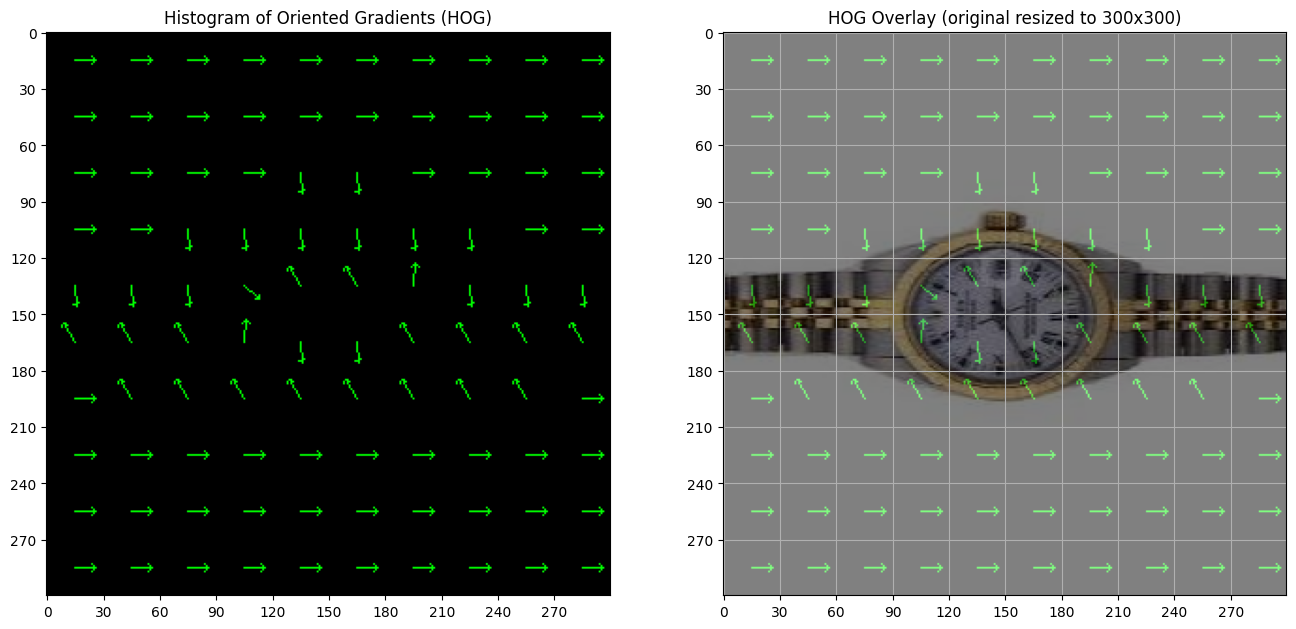

In [42]:
# Create a blank canvas to visualize the HOG features
block_size = 30
canvas = np.zeros((10 * block_size, 10 * block_size, 3), dtype=np.uint8)

# Define the arrow properties
base_arrow_length = block_size * 3 / 4  # Adjust as needed
arrow_color = (0, 255, 0)  # Green arrows for gradient direction

# Loop through each block in the HOG feature descriptor
for i in range(10):
    for j in range(10):
        block = hog_fd[i, j]
        x, y = j * block_size, i * block_size  # Top-left corner of the block

        # Compute the center position of the block
        center_x = x + block_size // 2
        center_y = y + block_size // 2

        # Find n most dominant directions (pairs of index and gradient magnitude in that direction)
        num_dir = 1
        dominant_directions = [pair for pair in sorted(
                list(enumerate(block)), key=lambda x: x[1], reverse=True
            )[:num_dir]
        ]

        for idx, (direction, magnitude) in enumerate(dominant_directions):
            arrow_thickness = num_dir - idx # decreasing thickness
            
            # Compute end points
            # arrow_start_x = int(
            #     center_x - ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            # )
            # arrow_start_y = int(
            #     center_y - ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2)
            # )
            arrow_end_x = int(
                center_x
                + ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            )
            arrow_end_y = int(
                center_y
                + ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2 )
            )

            # Draw the arrow on the canvas
            cv2.arrowedLine(
                canvas,
                (center_x, center_y),
                # (arrow_start_x, arrow_start_y),
                (arrow_end_x, arrow_end_y),
                arrow_color,
                thickness=arrow_thickness,
                tipLength=0.2,
            )

# Display the canvas with HOG arrows visualization alongside HOG overlay over resized image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=False)

ax1.imshow(canvas)
ax1.set_title('Histogram of Oriented Gradients (HOG)')

ax2.imshow(transforms.Resize((300,300))(sample_image))
ax2.imshow(canvas, alpha=0.5) # overlay HOG on image
# ax.imshow(transforms.Resize((300, 300))(sample_image))
ax2.set_title('HOG Overlay (original resized to 300x300)')

ax1.set_xticks(range(0, 300, 30))
ax1.set_yticks(range(0, 300, 30))
ax2.set_xticks(range(0, 300, 30))
ax2.set_yticks(range(0, 300, 30))
plt.grid()
plt.show()


## Working with ResNet50

In [ ]:
import torchvision.models as models

# use GPU (Nvidia)
if torch.cuda.is_available():
    dev = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    dev = torch.device("cpu")

print(f"Using {dev}")

# Load model
model = models.resnet50(models.ResNet50_Weights.DEFAULT)
model = model.to(dev)

# ResNet architecture in brief
model.eval()


#### ResNet50 - Feature extractor module (for ease of use - attach hooks at multiple layers at once)

In [ ]:
# Feature extractor for all layers at once


class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: None for layer in layers}  # store layer outputs here

        # Create hooks for all specified layers at once
        for layer_id in layers:
            layer = dict(self.model.named_modules())[layer_id]  # get actual layer in the model
            layer.register_forward_hook(self.save_outputs_hook(layer_id))  # register feature extractor hook on layer

    # Hook to save output of layer
    def save_outputs_hook(self, layer_id):
        def fn(_module, _input, output):
            self._features[layer_id] = output

        return fn

    # Forward pass returns extracted features
    def forward(self, input):
        _ = self.model(input)
        return self._features

Resize image to 224x224 with 3 channels for ResNet50 (no grayscale)

In [ ]:
resized_image = (
    torch.Tensor(np.array(transforms.Resize((224, 224))(sample_image)).flatten())
    .view(1, 3, 224, 224)
    .to(dev)
)


In [ ]:
# Attach all hooks on model and extract features

resnet_features = FeatureExtractor(model=model, layers=["avgpool", "layer3", "fc"])

features = resnet_features(resized_image)

print({name: output.shape for name, output in features.items()})


{'avgpool': torch.Size([1, 2048, 1, 1]), 'layer3': torch.Size([1, 1024, 14, 14]), 'fc': torch.Size([1, 1000])}


ResNet-AvgPool-1024

In [ ]:
avgpool_2048 = features["avgpool"]

# Reshape the vector into row pairs of elements and average across rows
avgpool_1024_fd = torch.mean(avgpool_2048.view(-1, 2), axis=1)

print(avgpool_2048.flatten())
print(avgpool_1024_fd)


tensor([1.9426, 2.6439, 0.0000,  ..., 0.0000, 0.8319, 0.0000], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor([2.2933, 0.0000, 2.4384,  ..., 0.0000, 0.0000, 0.4159], device='cuda:0',
       grad_fn=<MeanBackward1>)


ResNet-Layer3-1024

In [ ]:
layer3_1024_14_14 = features["layer3"]

# Reshape the vector into 1024 rows of 196 elements and average across rows
layer3_1024_fd = torch.mean(layer3_1024_14_14.view(1024, -1), axis=1)

print(layer3_1024_14_14)
print(layer3_1024_fd)


tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5682e+01, 4.2184e+01, 4.1923e+01,  ..., 3.6128e+01,
           3.8690e+01, 2.4934e+01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.5090e+02, 4.3473e+02, 3.5955e+02,  ..., 3.2161e+02,
           3.5421e+02, 2.8750e+02],
          [7.2420e+01, 1.5282e+02, 1.4668e+02,  ..., 1.2188e+02,
           1.3251e+02, 9.7097e+01],
          [1.4194e+01, 2.2164e+01, 2.1021e+01,  ..., 2.3378e+01,
           1.9422e+01, 1.5501e+01],
          ...,
          [1.7674e+01, 2.9534e+01, 2.8957e+01,  ..., 2.7021

ResNet-FC-1000

In [ ]:
fc_1000_fd = features['fc'].view(1000)

print(fc_1000_fd)

tensor([-1.6599e+01, -7.3065e+00, -9.9335e+00, -1.9164e+01, -1.4890e+01,
        -1.2751e+01, -1.0787e+01, -3.0016e+01, -1.4808e+01,  8.2885e+00,
         9.2186e+00, -4.6726e+01, -1.5658e+01, -1.3921e+01, -3.9682e+01,
        -6.2184e+00, -3.4682e+01, -1.5706e+01,  2.5679e+01, -7.3244e-01,
        -1.4558e+01, -7.1408e+00,  2.2808e+01,  4.2694e+01,  1.3051e+01,
        -7.2299e+00, -3.7666e+01, -7.7757e+00, -1.1570e+01,  1.4032e+01,
        -2.4568e+01,  5.0127e+00, -1.5342e+01, -3.5899e+00, -3.1899e+01,
        -6.2582e+00,  1.6825e+01, -2.2763e+01,  6.5692e+00, -8.2334e+00,
        -3.3320e+01, -1.1561e+01, -1.0618e+01,  1.8856e+01, -1.0095e+01,
        -1.8097e+01, -4.2079e+01, -8.0502e+00, -2.1285e+01, -1.4217e+01,
        -2.5346e+01, -8.8489e+00,  1.1895e+01,  9.8676e-01, -3.7103e+01,
        -5.0455e+00, -1.3847e+01, -3.5528e+01, -1.8539e+01,  2.3709e+01,
         6.2435e+01,  1.6605e+00, -3.9280e+00, -1.8692e+01,  1.5156e+01,
        -7.0797e+00, -9.6634e+00, -2.3084e+01, -1.9

In [ ]:
print(cm_fd.numpy().shape)
print(hog_fd.numpy().shape)
print(avgpool_1024_fd.detach().cpu().numpy().shape)
print(layer3_1024_fd.detach().cpu().numpy().shape)
print(fc_1000_fd.detach().cpu().numpy().shape)

(10, 10, 3, 3)
(10, 10, 9)
(1024,)
(1024,)
(1000,)
